In [2]:
import os
import numpy as np
import pandas as pd
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length
from TSB_UAD.utils.visualisation import plotFig
from TSB_UAD.models.damp import DAMP
from TSB_UAD.vus.metrics import get_metrics
from TSB_UAD.models.matrix_profile import MatrixProfile
from TSB_UAD.models.iforest import IForest
from TSB_UAD.models.imondrian.mondrianforest import MondrianForest
from TSB_UAD.models.sand import SAND
from sklearn.preprocessing import MinMaxScaler
import math 


# Read data -- create/read a normality-2 dataset named `combined.csv`
# filepath = "data/TSB-UAD-Public/ECG/MBA_ECG14046_data_9.out"
ts1 = "data/TSB-UAD-Public/ECG/MBA_ECG14046_data_9.out"
ts2 = "data/TSB-UAD-Public/ECG/MBA_ECG14046_data_20.out"
# df = pd.read_csv(filepath, header=None).dropna().to_numpy()

filepath = 'MBA_ECG14046_data_9_20.csv'
name = filepath.split('/')[-1]
if not os.path.exists(filepath):
    df1 = pd.read_csv(ts1, header=None).dropna().to_numpy()
    df2 = pd.read_csv(ts2, header=None).dropna().to_numpy()
    combined = np.vstack((df1, df2))
    pd.DataFrame(combined).to_csv(filepath, header=False, index=False)

df = pd.read_csv(filepath, header=None).dropna().to_numpy()
data = df[:, 0].astype(float)
labels = df[:, 1].astype(int)

In [3]:
# Preprocessing
# slidingWindow = 10 # user defined

# or auto sliding window length
slidingWindow = find_length(data)
X_data = Window(window=slidingWindow).convert(data).to_numpy()

In [4]:
def evaluate(score, modelName, slidingWindow, name, predict=True):
    from TSB_UAD.vus import metrics
    from importlib import reload
    metrics = reload(metrics)
    # post processing
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    if predict:
        score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
    results = metrics.get_metrics(score, labels, metric="all", slidingWindow=slidingWindow)
    for metric in results.keys():
        print(metric, ":", results[metric])
    plotFig(data[:len(score)], labels[:len(score)], score, slidingWindow, fileName=name, modelName=modelName)

AUC_ROC : 0.5377203165344974
AUC_PR : 0.10673764900112394
Precision : 0.30143784196462653
Recall : 0.10394910048266784
F : 0.15458905673920845
Precision_at_k : 0.10394910048266784
Rprecision : 0.26907917741642984
Rrecall : 0.09938210526322833
RF : 0.1451531348947283
R_AUC_ROC : 0.8206725071024382
R_AUC_PR : 0.2779464623639834
VUS_ROC : 0.7215768283114047
VUS_PR : 0.19099228230070384
Affiliation_Precision : 0.8122977849158274
Affiliation_Recall : 0.09200945640959314


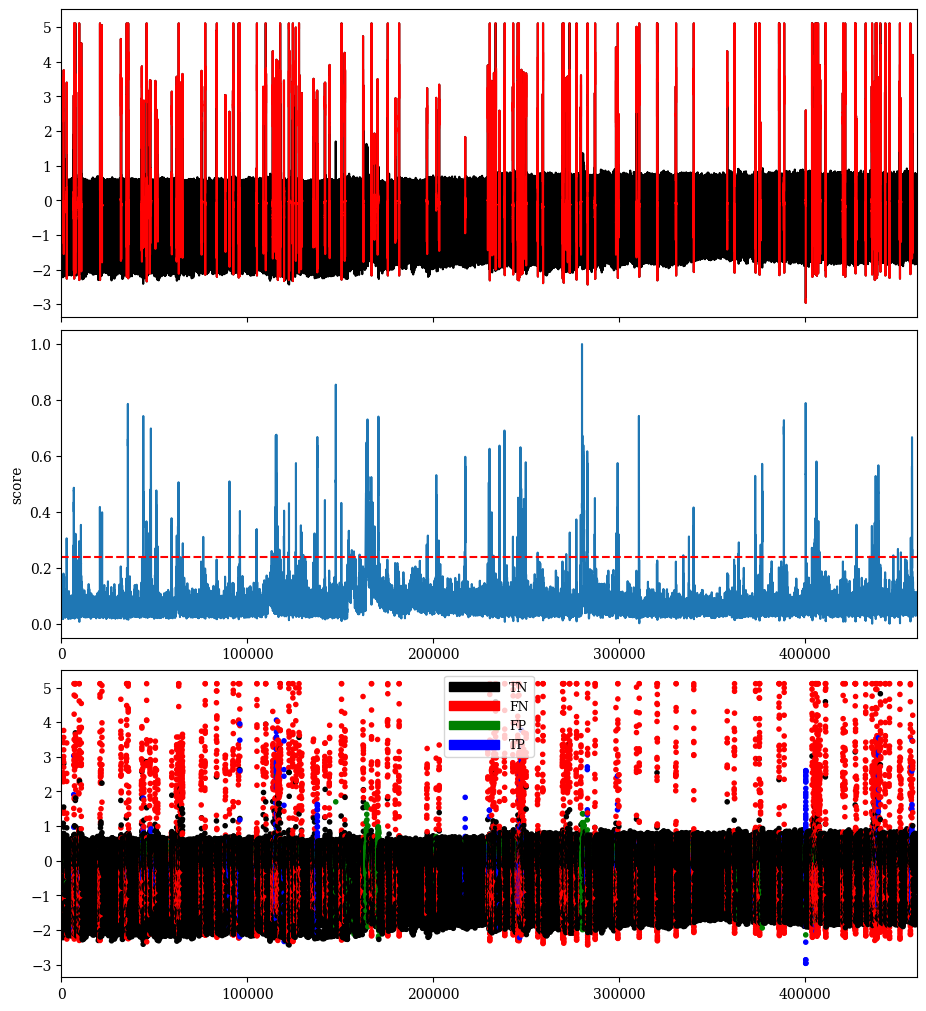

In [5]:
# Run MatrixProfile
modelName = 'MatrixProfile'
clf = MatrixProfile(window=slidingWindow) # takes 6 minutes
clf.fit(data)
score = clf.decision_scores_
evaluate(score, modelName, slidingWindow, name)

AUC_ROC : 0.9467402614353136
AUC_PR : 0.6756181505244989
Precision : 0.7077582403731014
Recall : 0.4927599824484423
F : 0.5810073207957163
Precision_at_k : 0.4927599824484423
Rprecision : 0.5330299840265508
Rrecall : 0.3872797486267722
RF : 0.44861357193121637
R_AUC_ROC : 0.9943459315950316
R_AUC_PR : 0.933627934971656
VUS_ROC : 0.9889463148954433
VUS_PR : 0.8561549710485107
Affiliation_Precision : 0.9519955979098097
Affiliation_Recall : 0.8327126651750504


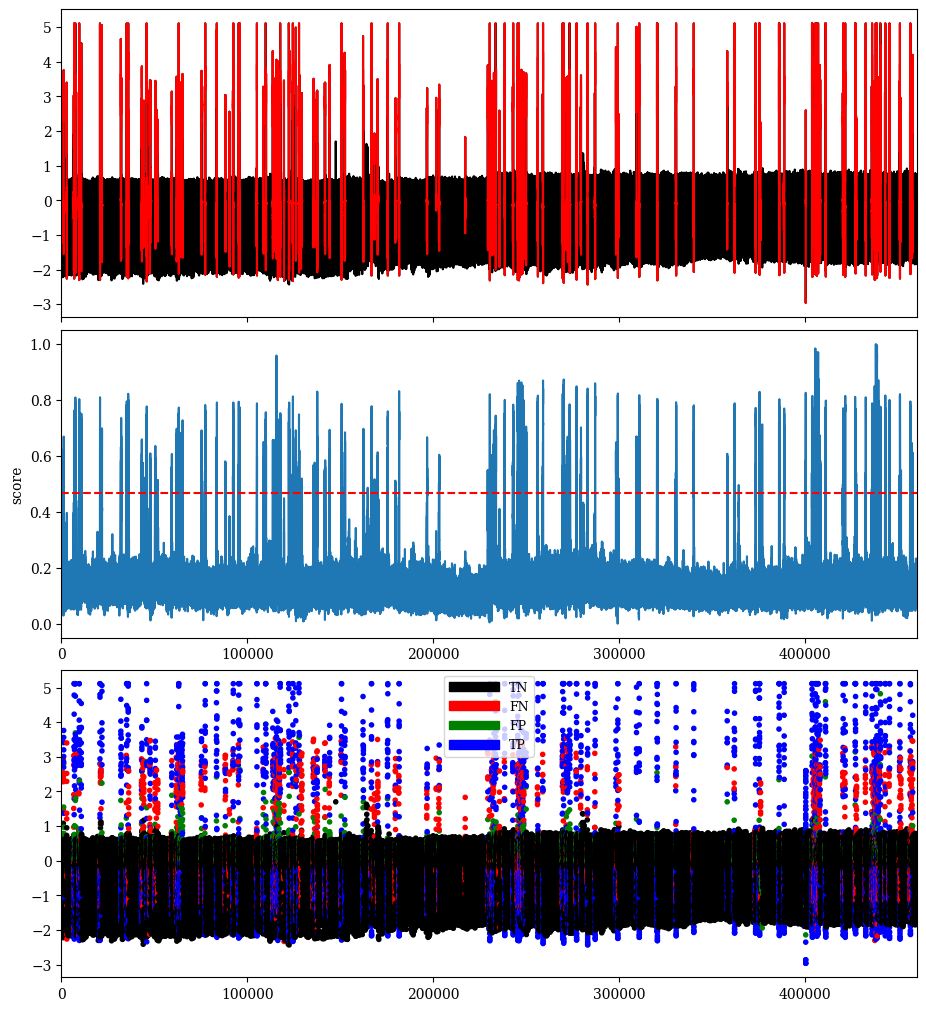

In [ ]:
# Run offline Isolation Forest
modelName = 'IForest'
clf = IForest(n_jobs=1) 
x = X_data
clf.fit(x) # runs in 1.5 mins
score = clf.decision_scores_
evaluate(score, modelName, slidingWindow, name)

0-->5000-->10000-->15000-->20000-->25000-->30000-->35000-->40000-->45000-->50000-->55000-->60000-->65000-->70000-->75000-->80000-->85000-->90000-->95000-->100000-->105000-->110000-->115000-->120000-->125000-->130000-->135000-->140000-->145000-->150000-->155000-->160000-->165000-->170000-->175000-->180000-->185000-->190000-->195000-->200000-->205000-->210000-->215000-->220000-->225000-->230000-->235000-->240000-->245000-->250000-->255000-->260000-->265000-->270000-->275000-->280000-->285000-->290000-->295000-->300000-->305000-->310000-->315000-->320000-->325000-->330000-->335000-->340000-->345000-->350000-->355000-->360000-->365000-->370000-->375000-->380000-->385000-->390000-->395000-->400000-->405000-->410000-->415000-->420000-->425000-->430000-->435000-->440000-->445000-->450000-->455000-->AUC_ROC : 0.9343794952936143
AUC_PR : 0.6288920494760907
Precision : 0.6528627355028138
Recall : 0.46831943835015355
F : 0.5454034442230058
Precision_at_k : 0.46831943835015355
Rprecision : 0.60131

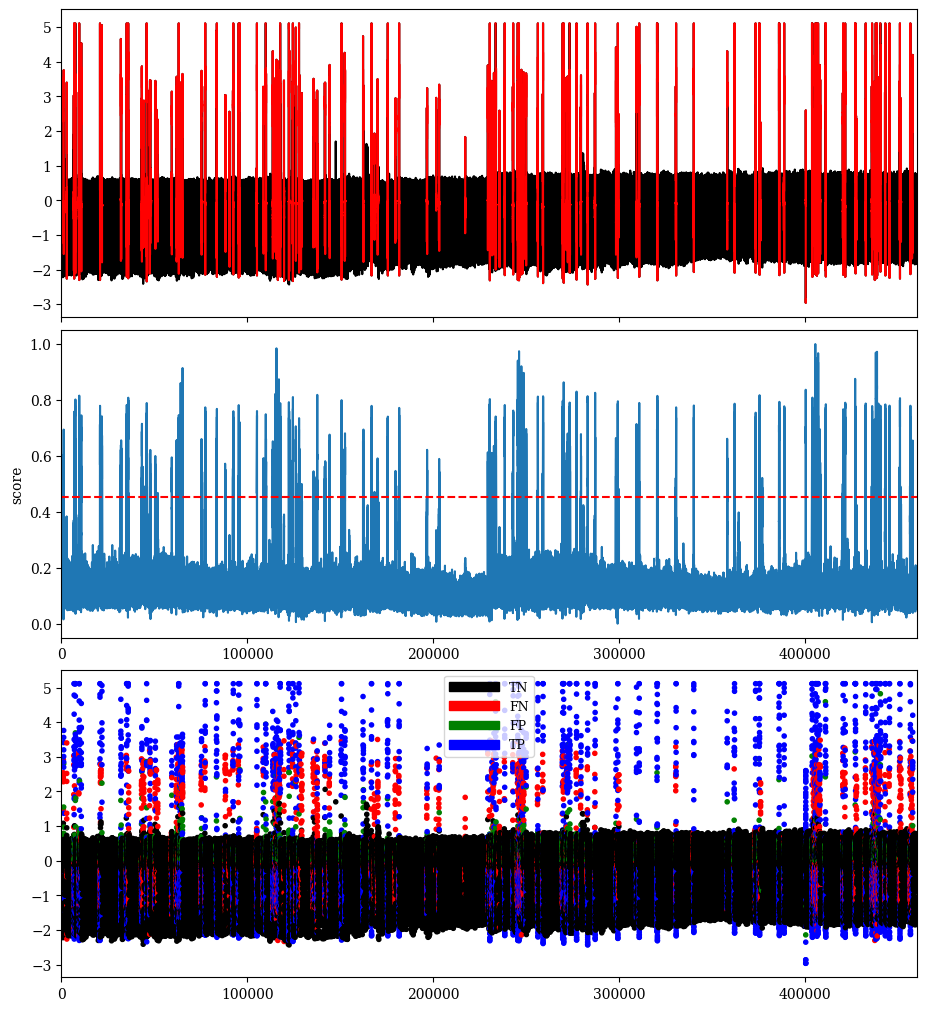

In [ ]:
# Run online Isolation Forest (variant 1)
modelName = 'IForest'
clf = IForest(n_jobs=1)
x = X_data
clf.fit(x, online=True, verbose=True, batch_size=5_000) # runs in 1.5 minutes
score = clf.decision_scores_
evaluate(score, modelName, slidingWindow, name)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Training on 459800 samples of dimension 1
0-->5000-->10000-->15000-->20000-->25000-->30000-->35000-->40000-->45000-->50000-->55000-->60000-->65000-->70000-->75000-->80000-->85000-->90000-->95000-->100000-->105000-->110000-->115000-->120000-->125000-->130000-->135000-->140000-->145000-->150000-->155000-->160000-->165000-->170000-->175000-->180000-->185000-->190000-->195000-->200000-->205000-->210000-->215000-->220000-->225000-->230000-->235000-->240000-->245000-->250000-->255000-->260000-->265000-->270000-->275000-->280000-->285000-->290000-->295000-->300000-->305000-->310000-->315000-->320000-->325000-->330000-->335000-->340000-->345000-->350000-->355000-->360000-->365000-->370000-->375000-->380000-->385000-->390000-->395000-->400000-->405000-->410000-->415000-->420000-->425000-->430000-->435000-->440000-->445000-->450000-->455000-->459800 [END]
AUC_ROC : 0.7074023656950242
AUC_PR : 0.27140449262176

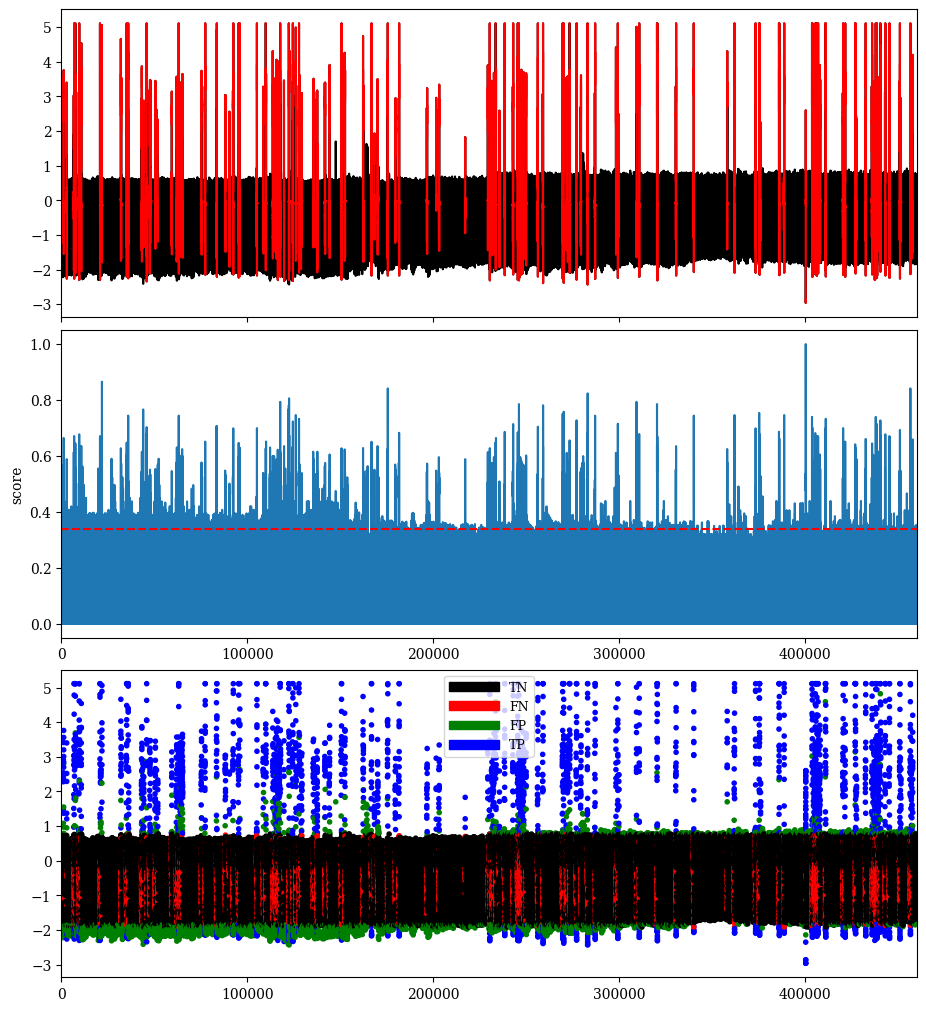

In [9]:
# Run online Isolation Forest (variant 2)
%load_ext autoreload
modelName = 'IForest (online variant 2)'
import warnings
warnings.filterwarnings('ignore') # this will make warm_start produce no warnings :)
clf = IForest(n_jobs=1)
x = data
# labels are our y/targets
clf.fit(X=x, y=labels, online=True, verbose=True, batch_size=5_000, variant=2) # takes 4 minutes to run
score = clf.decision_scores_
evaluate(score, modelName, slidingWindow, name, predict=False) # takes another 5 minutes to evaluate 
# total runtime 10 minutes approx.

In [ ]:
# SAND online
# ---- WARNING: this takese 40 mins to complete!!
modelName = 'SAND (online)'
clf = SAND(pattern_length=slidingWindow, subsequence_length=4*slidingWindow)
# length = len(data)//100 # not sure ?
clf.fit(data, overlaping_rate=int(4*slidingWindow), online=True, alpha=.5, init_length=5000, batch_size=2000,verbose=True,) # 100 batches 
score = clf.decision_scores_
evaluate(score, modelName, name=name, slidingWindow=slidingWindow, predict=False)

0-->5000-->7000-->9000-->11000-->13000-->15000-->17000-->19000-->21000-->23000-->25000-->27000-->29000-->31000-->33000-->35000-->37000-->39000-->41000-->43000-->45000-->47000-->49000-->51000-->53000-->55000-->57000-->59000-->61000-->63000-->65000-->67000-->69000-->71000-->73000-->75000-->77000-->79000-->81000-->83000-->85000-->87000-->89000-->91000-->93000-->95000-->97000-->99000-->101000-->103000-->105000-->107000-->109000-->111000-->113000-->115000-->117000-->119000-->121000-->123000-->125000-->127000-->129000-->131000-->133000-->135000-->137000-->139000-->141000-->143000-->145000-->147000-->149000-->151000-->153000-->155000-->157000-->159000-->161000-->163000-->165000-->167000-->169000-->171000-->173000-->175000-->177000-->179000-->181000-->183000-->185000-->187000-->189000-->191000-->193000-->195000-->197000-->199000-->201000-->203000-->205000-->207000-->209000-->211000-->213000-->215000-->217000-->219000-->221000-->223000-->225000-->227000-->229000-->231000-->233000-->235000-->237

TypeError: evaluate() takes 2 positional arguments but 4 were given